In [ ]:
import _03_determine_topology

# Larger batch size improved correlations
model = _03_determine_topology.run(epochs=24, batch_size=2*1024)

#### Correlations according to weight matrix

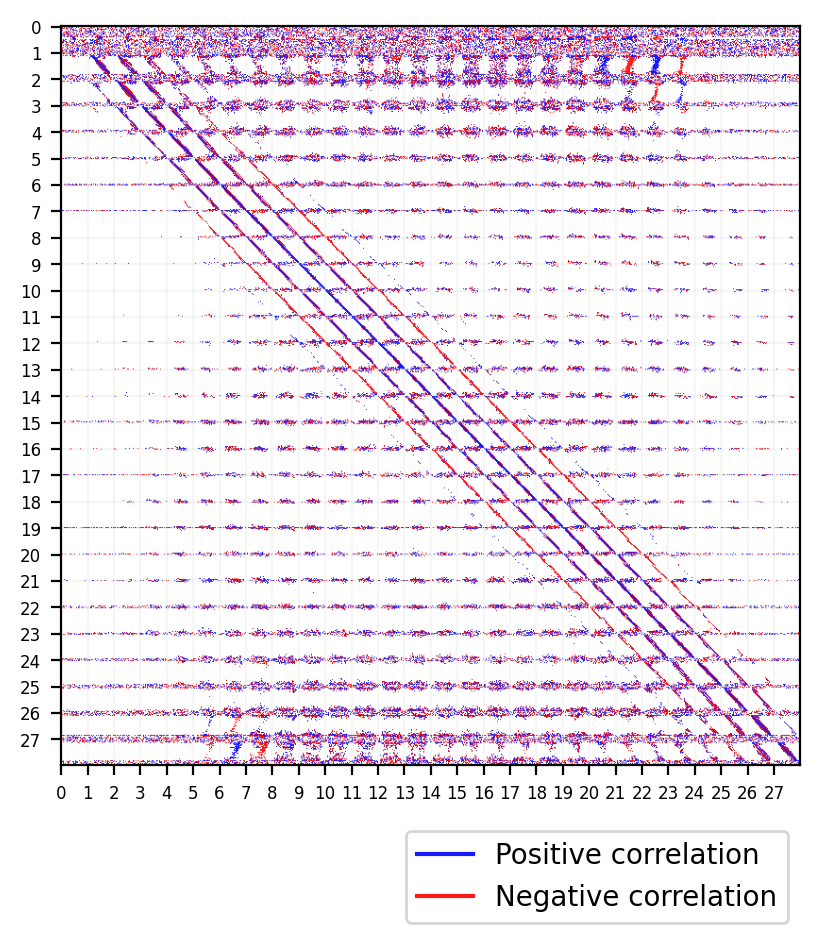

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import torch
import matplotlib
%config InlineBackend.figure_formats = "retina"

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Pixel positions undergo a fixed permutation to prevent
# structure from leaking into the model.
# Undo this permutation for visualization.
data = model.parameters().__next__().data.cpu()
data = data[model.unpermutation].T[model.unpermutation]

background = torch.ones_like(data)
image = torch.stack([background, background, background]).permute(1, 2, 0)

negative_color = torch.tensor([1.0, 0.1, 0.1])
positive_color = torch.tensor([0.1, 0.1, 1.0])
image[data < -0.02] *= negative_color
image[data > 0.02] *= positive_color

image = (image*255).byte()

image = PIL.Image.fromarray(image.numpy(), mode="RGB")
plt.imshow(image);

plt.xticks(np.arange(28)*28, np.arange(28), size=6)
plt.yticks(np.arange(28)*28, np.arange(28), size=6)
plt.grid(alpha=0.1)

plt.legend(handles=[
    matplotlib.lines.Line2D([0], [0], c=positive_color.tolist(), label="Positive correlation"),
    matplotlib.lines.Line2D([0], [0], c=negative_color.tolist(), label="Negative correlation"),
    ], bbox_to_anchor=(1.003, -0.07))

#### Topology based on threshold

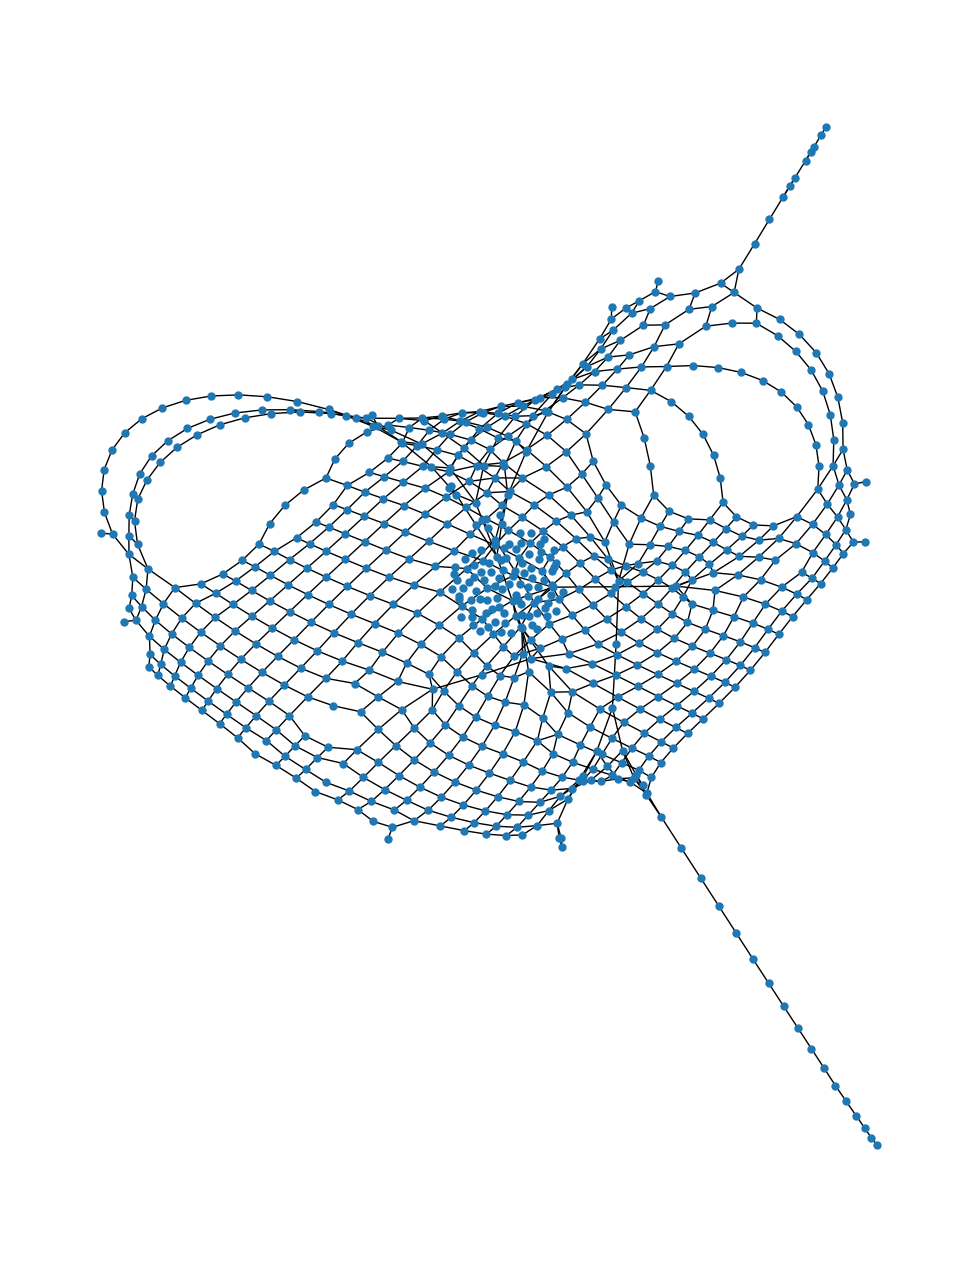

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = "retina"

data = model.parameters().__next__().data.cpu().numpy()
# data = data[model.unpermutation].T[model.unpermutation]

data = (data + data.T) / 2
np.fill_diagonal(data, 0)

thresholded = data > 0.1

# PIL.Image.fromarray(~thresholded)
# indices = np.indices(thresholded.shape).T[thresholded]

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

graph = nx.from_numpy_array(thresholded)
positions = nx.spring_layout(graph, iterations=200)
nx.draw(graph, positions, ax=ax, node_size=4, width=0.5)

#### Grid for reference

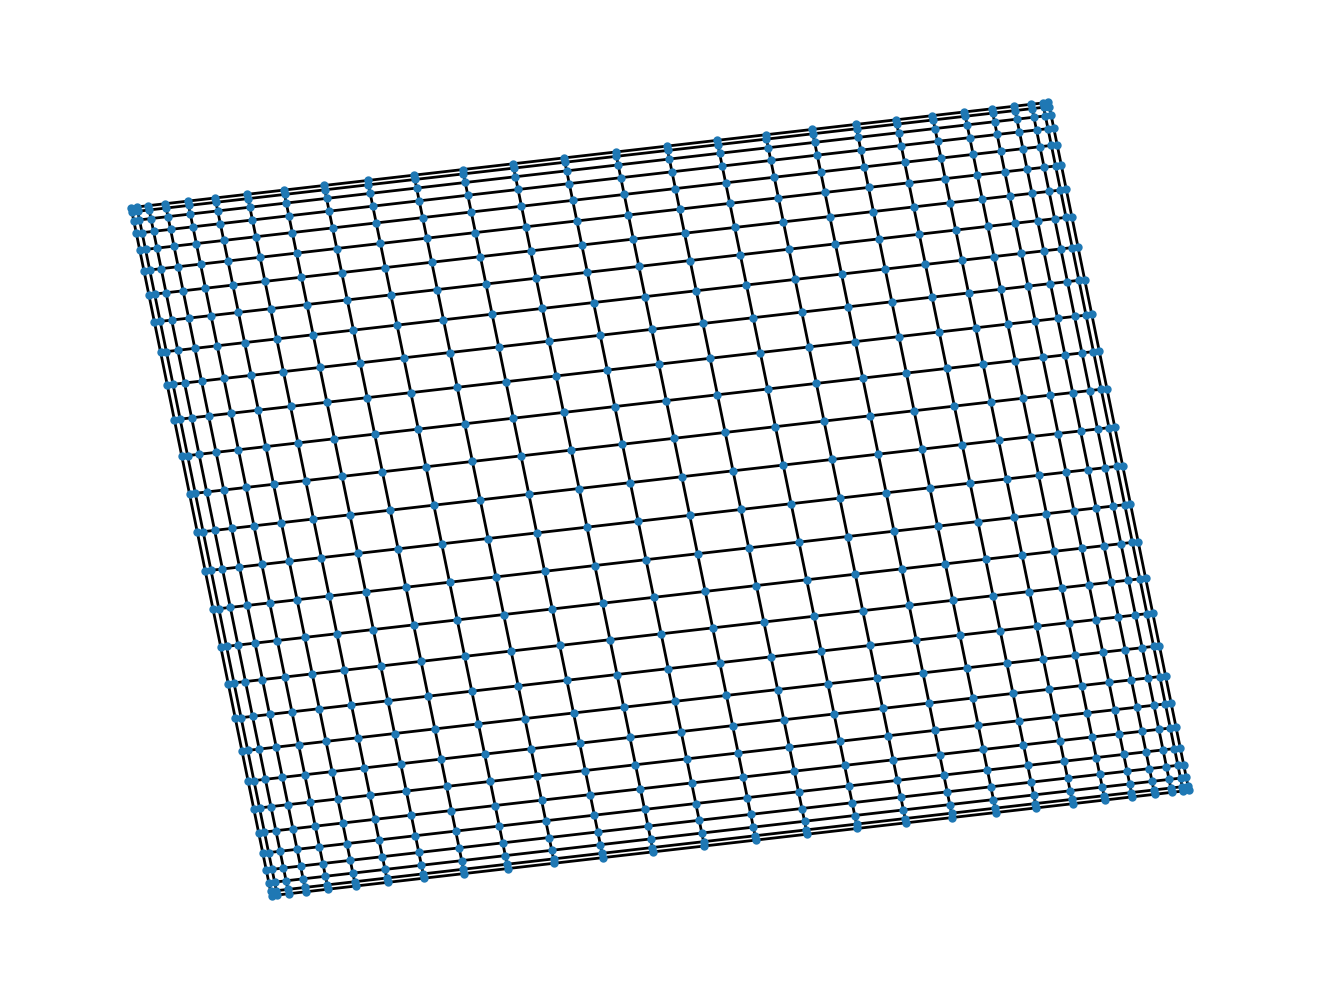

In [ ]:
grid = [(i, j)
        for i in range(28)
        for j in range(28)]

edges = [[[(i, j), (i+1, j)],
          [(i, j), (i, j+1)]]
         for i, j in grid]

edges = np.array(edges)
edges = edges.reshape(28*28*2, 2, 2)
edges = edges[(edges[:,1,0] < 28) & (edges[:,1,1] < 28)]


ids = dict(map(reversed, enumerate(grid)))
idd = np.array([ids[tuple(node)]
                for node in edges.reshape(-1, 2)])

edges_idd = idd.reshape(len(edges), 2)

frame = np.zeros((28*28, 28*28), dtype=np.bool)

for node1, node2 in edges_idd:
    frame[node1,node2] = True
    frame[node2,node1] = True

graph = nx.from_numpy_array(frame)
positions = nx.spectral_layout(graph)
nx.draw(graph, positions, node_size=4)